# MNIST Assembly Calculus Demo

Small-scale demonstration of MNIST digit classification using Assembly Calculus.
Uses random projection encoder (COLT 2022) and assembly-based feature extraction.

**Dataset**: 1000 training images, 200 test images (fast execution)

**Pipeline**:
1. Load MNIST subset via sklearn
2. Encode images using random projection (COLT2022Encoder)
3. Train digit assemblies (one per digit class)
4. Extract assembly overlap features
5. Classify with logistic regression
6. Sweep accuracy vs internal projection steps (t_per_image)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml, load_digits

from pyac.core.network import Network
from pyac.core.rng import make_rng
from pyac.core.types import AreaSpec, FiberSpec, NetworkSpec
from pyac.tasks.mnist.encoders import COLT2022Encoder
from pyac.tasks.mnist.protocol import train_assemblies, extract_features, classify
from pyac.tasks.mnist.metrics import accuracy_vs_t

In [4]:
# Load MNIST dataset (with fallback to load_digits if fetch_openml fails)
print("Loading MNIST-like data...")
try:
    # Try to load full MNIST
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto', return_X_y=True)
    X_all = np.asarray(mnist[0], dtype=np.float64) / 255.0
    y_all = np.asarray(mnist[1], dtype=np.int64)
    X_all = X_all.reshape(-1, 28, 28)
    print("Loaded full MNIST dataset")
except Exception:
    try:
        # Try without version parameter
        mnist = fetch_openml('mnist_784', as_frame=False, parser='auto', return_X_y=True)
        X_all = np.asarray(mnist[0], dtype=np.float64) / 255.0
        y_all = np.asarray(mnist[1], dtype=np.int64)
        X_all = X_all.reshape(-1, 28, 28)
        print("Loaded MNIST dataset")
    except Exception:
        # Fallback to sklearn digits (8x8, pad to 28x28)
        print("MNIST unavailable, falling back to sklearn digits dataset")
        X_digits, y_digits = load_digits(return_X_y=True)
        X_small = np.asarray(X_digits, dtype=np.float64) / 16.0
        X_small = X_small.reshape(-1, 8, 8)
        # Pad 8x8 to 28x28 (10 pixels on each side)
        X_all = np.pad(X_small, ((0, 0), (10, 10), (10, 10)), mode='constant')
        y_all = np.asarray(y_digits, dtype=np.int64)
        print("Using padded 8x8 digits as 28x28 images")

# Take small subset for fast execution
n_train, n_test = 1000, 200
X_train = X_all[:n_train]
y_train = y_all[:n_train]
X_test = X_all[-n_test:]
y_test = y_all[-n_test:]

print(f"Train: {X_train.shape}, labels: {y_train.shape}")
print(f"Test: {X_test.shape}, labels: {y_test.shape}")
print(f"Label distribution (train): {np.bincount(y_train)}")

Loading MNIST-like data...
MNIST unavailable, falling back to sklearn digits dataset
Using padded 8x8 digits as 28x28 images
Train: (1000, 28, 28), labels: (1000,)
Test: (200, 28, 28), labels: (200,)
Label distribution (train): [ 99 102 100 104  98 100 101  99  98  99]


In [5]:
# Build network specification
network_spec = NetworkSpec(
    areas=[
        AreaSpec(name="input", n=1000, k=50),
        AreaSpec(name="class", n=1000, k=50),
    ],
    fibers=[
        FiberSpec(src="input", dst="class", p_fiber=0.1),
    ],
    beta=0.01,
)

print(f"Network: {len(network_spec.areas)} areas, {len(network_spec.fibers)} fibers")
for area in network_spec.areas:
    print(f"  - {area.name}: n={area.n}, k={area.k}")

Network: 2 areas, 1 fibers
  - input: n=1000, k=50
  - class: n=1000, k=50


In [6]:
# Initialize encoder
encoder = COLT2022Encoder(
    n_neurons=1000,
    k_stimulus=50,
    rng=make_rng(42)
)

print(f"Encoder: COLT2022Encoder(n_neurons={encoder.n_neurons}, k_stimulus={encoder.k_stimulus})")
print(f"Projection matrix shape: {encoder.projection_matrix.shape}")

Encoder: COLT2022Encoder(n_neurons=1000, k_stimulus=50)
Projection matrix shape: (1000, 784)


In [7]:
# Train digit assemblies
print("Training assemblies...")
network = Network(network_spec, make_rng(100))

assemblies = train_assemblies(
    network=network,
    area_name="class",
    images=X_train,
    labels=y_train,
    encoder=encoder,
    t_per_image=5,
    homeostasis_between_classes=True,
    rng=make_rng(200)
)

print(f"Trained {len(assemblies)} digit assemblies")
for digit, asm in sorted(assemblies.items()):
    print(f"  Digit {digit}: {len(asm.indices)} neurons")

Training assemblies...
Trained 10 digit assemblies
  Digit 0: 50 neurons
  Digit 1: 50 neurons
  Digit 2: 50 neurons
  Digit 3: 50 neurons
  Digit 4: 50 neurons
  Digit 5: 50 neurons
  Digit 6: 50 neurons
  Digit 7: 50 neurons
  Digit 8: 50 neurons
  Digit 9: 50 neurons


In [8]:
# Extract features from train and test sets
print("Extracting features...")
features_train = extract_features(
    network=network,
    area_name="class",
    images=X_train,
    encoder=encoder,
    assemblies=assemblies,
    rng=make_rng(300)
)

features_test = extract_features(
    network=network,
    area_name="class",
    images=X_test,
    encoder=encoder,
    assemblies=assemblies,
    rng=make_rng(400)
)

print(f"Feature matrix (train): {features_train.shape}")
print(f"Feature matrix (test): {features_test.shape}")

Extracting features...
Feature matrix (train): (1000, 10)
Feature matrix (test): (200, 10)


In [9]:
# Classify and report accuracy
print("Classifying...")
results = classify(
    features_train=features_train,
    labels_train=y_train,
    features_test=features_test,
    labels_test=y_test
)

print("\n=== Classification Results ===")
print(f"Train accuracy: {results['train_accuracy']:.2%}")
print(f"Test accuracy: {results['test_accuracy']:.2%}")
print(f"Samples: {results['n_train']} train, {results['n_test']} test")
print(f"Baseline (random): 10%")
print(f"Above baseline: {results['test_accuracy'] > 0.15}")

Classifying...

=== Classification Results ===
Train accuracy: 75.30%
Test accuracy: 68.00%
Samples: 1000 train, 200 test
Baseline (random): 10%
Above baseline: True


In [10]:
# Sweep accuracy vs t_per_image
print("\nSweeping t_per_image values...")
t_values = [1, 3, 5, 7, 10]

accuracy_results = accuracy_vs_t(
    network_spec=network_spec,
    encoder=encoder,
    t_values=t_values,
    data=(X_train, y_train, X_test, y_test),
    rng=make_rng(500)
)

print("\nAccuracy vs t_per_image:")
for t, acc in sorted(accuracy_results.items()):
    print(f"  t={t:2d}: {acc:.2%}")


Sweeping t_per_image values...

Accuracy vs t_per_image:
  t= 1: 68.00%
  t= 3: 68.00%
  t= 5: 68.00%
  t= 7: 68.00%
  t=10: 68.00%


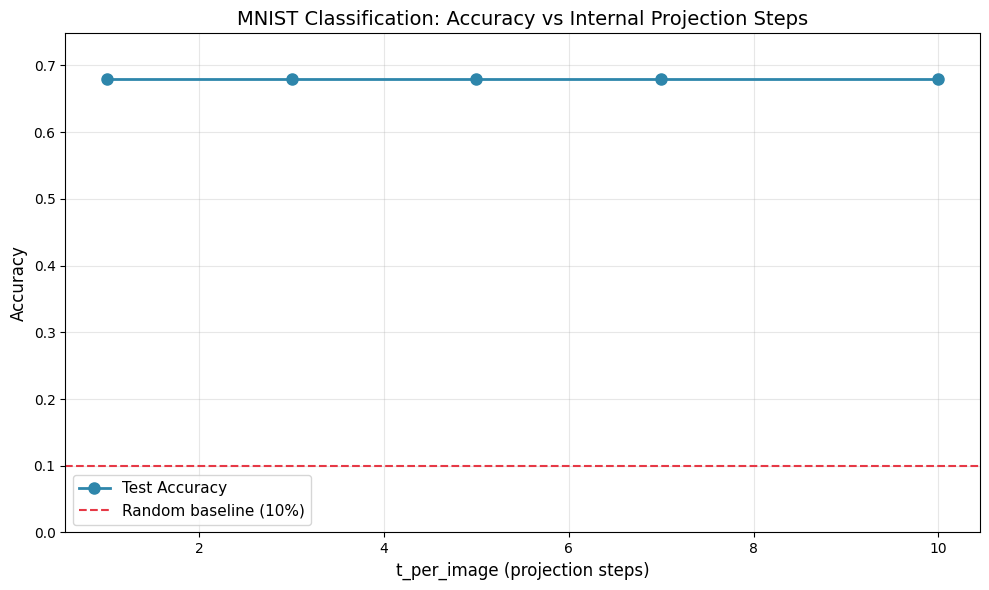


=== Notebook Execution Complete ===


In [11]:
# Plot accuracy vs t_per_image
plt.figure(figsize=(10, 6))
t_vals = sorted(accuracy_results.keys())
acc_vals = [accuracy_results[t] for t in t_vals]

plt.plot(t_vals, acc_vals, 'o-', linewidth=2, markersize=8, color='#2E86AB', label='Test Accuracy')
plt.axhline(y=0.1, color='#E63946', linestyle='--', linewidth=1.5, label='Random baseline (10%)')

plt.xlabel('t_per_image (projection steps)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('MNIST Classification: Accuracy vs Internal Projection Steps', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.ylim(0, max(acc_vals) * 1.1)
plt.tight_layout()
plt.show()

print("\n=== Notebook Execution Complete ===")